# BACKGROUND

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

a random forest is an ensemble classifier that consists of many trees and outputs a class that is the mode of the class's output by individual trees
takes the average (entropy/information gain) of many decision trees via bagging (bootstrap aggregation)
bootstrap aggregation: samples are chosen with replacement (bootstrap), and combined (aggregated) by taking their average

In [18]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
import datetime
import warnings

from pandas import to_datetime
from itertools import product
# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report
from collections import Counter

# from operator import index
# from sklearn import neural_network

# DEFINITIONS & CONFIGS

Configurations

In [19]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)
# matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

Function Definitions

In [20]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# scaling/normalizing a list of columns using fit_transform
def fit_trans_columns(df,columns:list=[str]):
    scaler = MinMaxScaler()
    scaled_df = df.copy()
    scaled_df[columns] = scaler.fit_transform(scaled_df[columns])
    return scaled_df

# Custom Boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, figsize=(13,5)) # sharey=True
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers


# LOADING DATASET

In [21]:
data = "/Users/bakerhabhab/Desktop/LIBRARIES/Document Library/CODING/python_projects/ece576project/src/data/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(data)


# DATA PRE-PROCESSING

## Dataset Info

In [22]:
print(f'shape: {df.shape}\n')
df.head()
# yes,no columns: anaemia, diabetes, high_blood_pressure, sex, smoking

shape: (299, 13)



age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [23]:
df.describe().T

count           mean           std      min  \
age                       299.0      60.833893     11.894809     40.0   
anaemia                   299.0       0.431438      0.496107      0.0   
creatinine_phosphokinase  299.0     581.839465    970.287881     23.0   
diabetes                  299.0       0.418060      0.494067      0.0   
ejection_fraction         299.0      38.083612     11.834841     14.0   
high_blood_pressure       299.0       0.351171      0.478136      0.0   
platelets                 299.0  263358.029264  97804.236869  25100.0   
serum_creatinine          299.0       1.393880      1.034510      0.5   
serum_sodium              299.0     136.625418      4.412477    113.0   
sex                       299.0       0.648829      0.478136      0.0   
smoking                   299.0       0.321070      0.467670      0.0   
time                      299.0     130.260870     77.614208      4.0   
DEATH_EVENT               299.0       0.321070      0.467670      0.0   

                               25%       50%       75%       max  
age                           51.0      60.0      70.0      95.0  
anaemia                        0.0       0.0       1.0       1.0  
creatinine_phosphokinase     116.5     250.0     582.0    7861.0  
diabetes                       0.0       0.0       1.0       1.0  
ejection_fraction             30.0      38.0      45.0      80.0  
high_blood_pressure            0.0       0.0       1.0       1.0  
platelets                 212500.0  262000.0  303500.0  850000.0  
serum_creatinine               0.9       1.1       1.4       9.4  
serum_sodium                 134.0     137.0     140.0     148.0  
sex                            0.0       1.0       1.0       1.0  
smoking                        0.0       0.0       1.0       1.0  
time                          73.0     115.0     203.0     285.0  
DEATH_EVENT                    0.0       0.0       1.0       1.0

In [24]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

Checking for null values

In [25]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [26]:
# getting distinct counts per column and printing them out if less than 20
for col in df:
    unique_val = pd.unique(df[col])
    nr_val = len(unique_val)
    if nr_val <=20:
        print(f'num of vals for feature: column: {col}, count: {nr_val}, values: {unique_val}')
    else:
        print(f'num of vals for feature: column: {col}, count: {nr_val}')

num of vals for feature: column: age, count: 47
num of vals for feature: column: anaemia, count: 2, values: [0 1]
num of vals for feature: column: creatinine_phosphokinase, count: 208
num of vals for feature: column: diabetes, count: 2, values: [0 1]
num of vals for feature: column: ejection_fraction, count: 17, values: [20 38 40 15 60 65 35 25 30 50 14 55 45 62 80 17 70]
num of vals for feature: column: high_blood_pressure, count: 2, values: [1 0]
num of vals for feature: column: platelets, count: 176
num of vals for feature: column: serum_creatinine, count: 40
num of vals for feature: column: serum_sodium, count: 27
num of vals for feature: column: sex, count: 2, values: [1 0]
num of vals for feature: column: smoking, count: 2, values: [0 1]
num of vals for feature: column: time, count: 148
num of vals for feature: column: DEATH_EVENT, count: 2, values: [1 0]


## Detecting Outliers

Boxplots

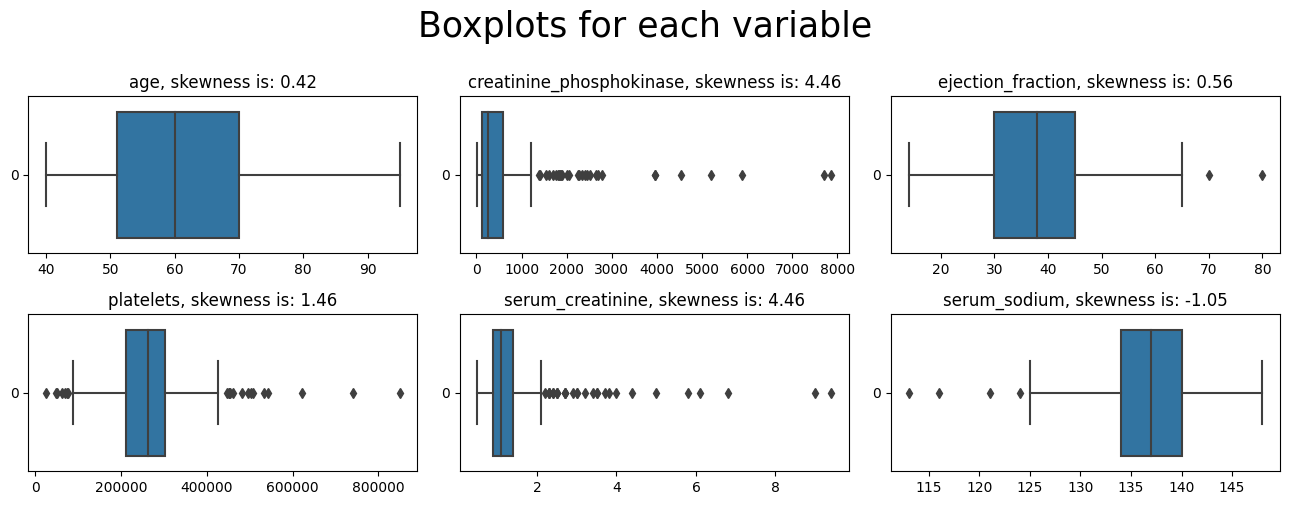

In [27]:
# checking boxplots
numerical_columns = list(df.loc[:,['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine','serum_sodium']])
categorical_columns = list(df.loc[:,['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']])
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

# Data Manipulation & Modification

In [28]:
new_df = df.copy()

## Working with Numerical Data

Dropping Outliers

In [29]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numerical_columns)

# dropping outliers
new_df = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)
new_df.shape

Total number of deleted outliers is: 4


(289, 13)

## Modifying the database values

In [30]:
columns_to_replace = ['anaemia', 'diabetes', 'sex', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']
for ind,column in enumerate(columns_to_replace):
    if column == 'sex':
        new_df.loc[:,column] = new_df[column].replace([1,0],['male','female'])
    new_df.loc[:,column] = new_df[column].replace([1,0],['yes','no'])


new_df.head(15)

age anaemia  creatinine_phosphokinase diabetes  ejection_fraction  \
0   75.0      no                       582       no                 20   
1   55.0      no                      7861       no                 38   
2   65.0      no                       146       no                 20   
3   50.0     yes                       111       no                 20   
4   90.0     yes                        47       no                 40   
5   75.0     yes                       246       no                 15   
6   60.0     yes                       315      yes                 60   
7   65.0      no                       157       no                 65   
8   80.0     yes                       123       no                 35   
9   75.0     yes                        81       no                 38   
10  62.0      no                       231       no                 25   
11  45.0     yes                       981       no                 30   
12  50.0     yes                       168       no                 38   
13  49.0     yes                        80       no                 30   
14  82.0     yes                       379       no                 50   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium     sex  \
0                  yes  265000.00               1.9           130    male   
1                   no  263358.03               1.1           136    male   
2                   no  162000.00               1.3           129    male   
3                   no  210000.00               1.9           137    male   
4                  yes  204000.00               2.1           132    male   
5                   no  127000.00               1.2           137    male   
6                   no  454000.00               1.1           131    male   
7                   no  263358.03               1.5           138  female   
8                  yes  388000.00               9.4           133    male   
9                  yes  368000.00               4.0           131    male   
10                 yes  253000.00               0.9           140    male   
11                  no  136000.00               1.1           137    male   
12                 yes  276000.00               1.1           137    male   
13                 yes  427000.00               1.0           138  female   
14                  no   47000.00               1.3           136    male   

   smoking  time DEATH_EVENT  
0       no     4         yes  
1       no     6         yes  
2      yes     7         yes  
3       no     7         yes  
4      yes     8         yes  
5       no    10         yes  
6      yes    10         yes  
7       no    10         yes  
8      yes    10         yes  
9      yes    10         yes  
10     yes    10         yes  
11      no    11         yes  
12      no    11         yes  
13      no    12          no  
14      no    13         yes

## Working with Categorical Data

Scaling Columns

In [31]:

# normalizing the numerical columns
norm_columns = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
norm_df = fit_trans_columns(df, numerical_columns)
# dropping the outliers as before
Outliers_IQR = IQR_method(df,1,numerical_columns)
norm_df = norm_df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)
norm_df.shape

norm_df.head()

Total number of deleted outliers is: 4


age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  0.636364        0                  0.071319         0           0.090909   
1  0.272727        0                  1.000000         0           0.363636   
2  0.454545        0                  0.015693         0           0.090909   
3  0.181818        1                  0.011227         0           0.090909   
4  0.909091        1                  0.003062         0           0.393939   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1   0.290823          0.157303      0.485714    1   
1                    0   0.288833          0.067416      0.657143    1   
2                    0   0.165960          0.089888      0.457143    1   
3                    0   0.224148          0.157303      0.685714    1   
4                    1   0.216875          0.179775      0.542857    1   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        1     8            1

In [32]:
norm_df.describe().T

count        mean        std  min        25%  \
age                       289.0    0.378631   0.217078  0.0   0.200000   
anaemia                   289.0    0.429066   0.495801  0.0   0.000000   
creatinine_phosphokinase  289.0    0.067635   0.120573  0.0   0.011738   
diabetes                  289.0    0.411765   0.493007  0.0   0.000000   
ejection_fraction         289.0    0.361697   0.174942  0.0   0.242424   
high_blood_pressure       289.0    0.359862   0.480792  0.0   0.000000   
platelets                 289.0    0.289123   0.110422  0.0   0.230210   
serum_creatinine          289.0    0.093608   0.098469  0.0   0.044944   
serum_sodium              289.0    0.675531   0.121968  0.0   0.600000   
sex                       289.0    0.657439   0.475389  0.0   0.000000   
smoking                   289.0    0.328720   0.470563  0.0   0.000000   
time                      289.0  130.110727  77.225600  4.0  73.000000   
DEATH_EVENT               289.0    0.314879   0.465273  0.0   0.000000   

                                 50%         75%    max  
age                         0.363636    0.545455    1.0  
anaemia                     0.000000    1.000000    1.0  
creatinine_phosphokinase    0.028706    0.071319    1.0  
diabetes                    0.000000    1.000000    1.0  
ejection_fraction           0.363636    0.469697    1.0  
high_blood_pressure         0.000000    1.000000    1.0  
platelets                   0.287186    0.335677    1.0  
serum_creatinine            0.067416    0.101124    1.0  
serum_sodium                0.685714    0.771429    1.0  
sex                         1.000000    1.000000    1.0  
smoking                     0.000000    1.000000    1.0  
time                      113.000000  205.000000  285.0  
DEATH_EVENT                 0.000000    1.000000    1.0

# DATA ANALYSIS & VISUALIZATION

Binary Distribution of Categorical Data

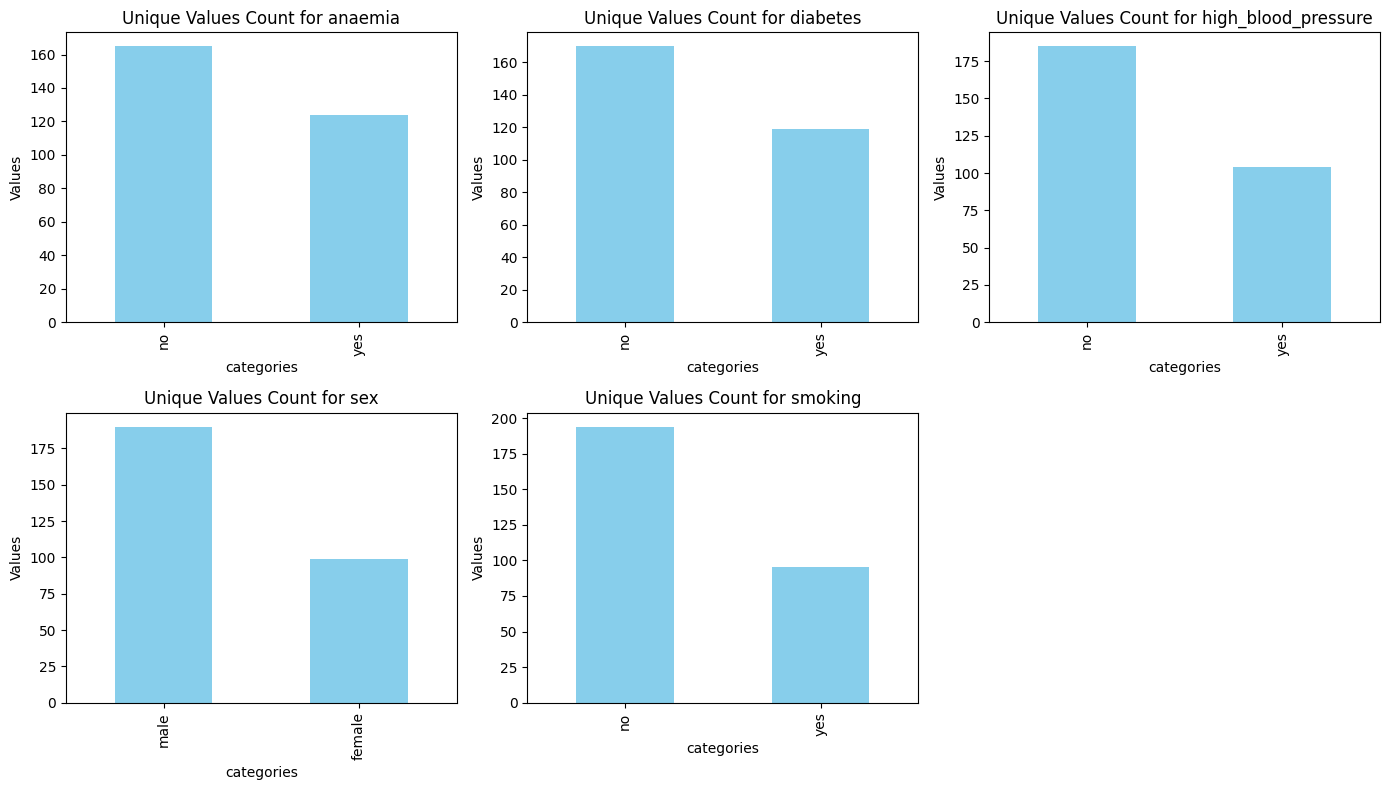

In [33]:
columns_to_plot = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))  # 3 rows, 2 columns

# Flattening the axes array for easier iteration
axes = axes.flatten()

# Setting up Bar plots
for i, ax in enumerate(axes[:len(columns_to_plot)]):
    column = columns_to_plot[i]
    value_counts = new_df[column].value_counts()
    value_counts.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Unique Values Count for {column}')
    ax.set_xlabel('categories')
    ax.set_ylabel('Values')

# Hiding the remaining subplot(s) if not used
for ax in axes[len(columns_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


Distribution of Numerical Data

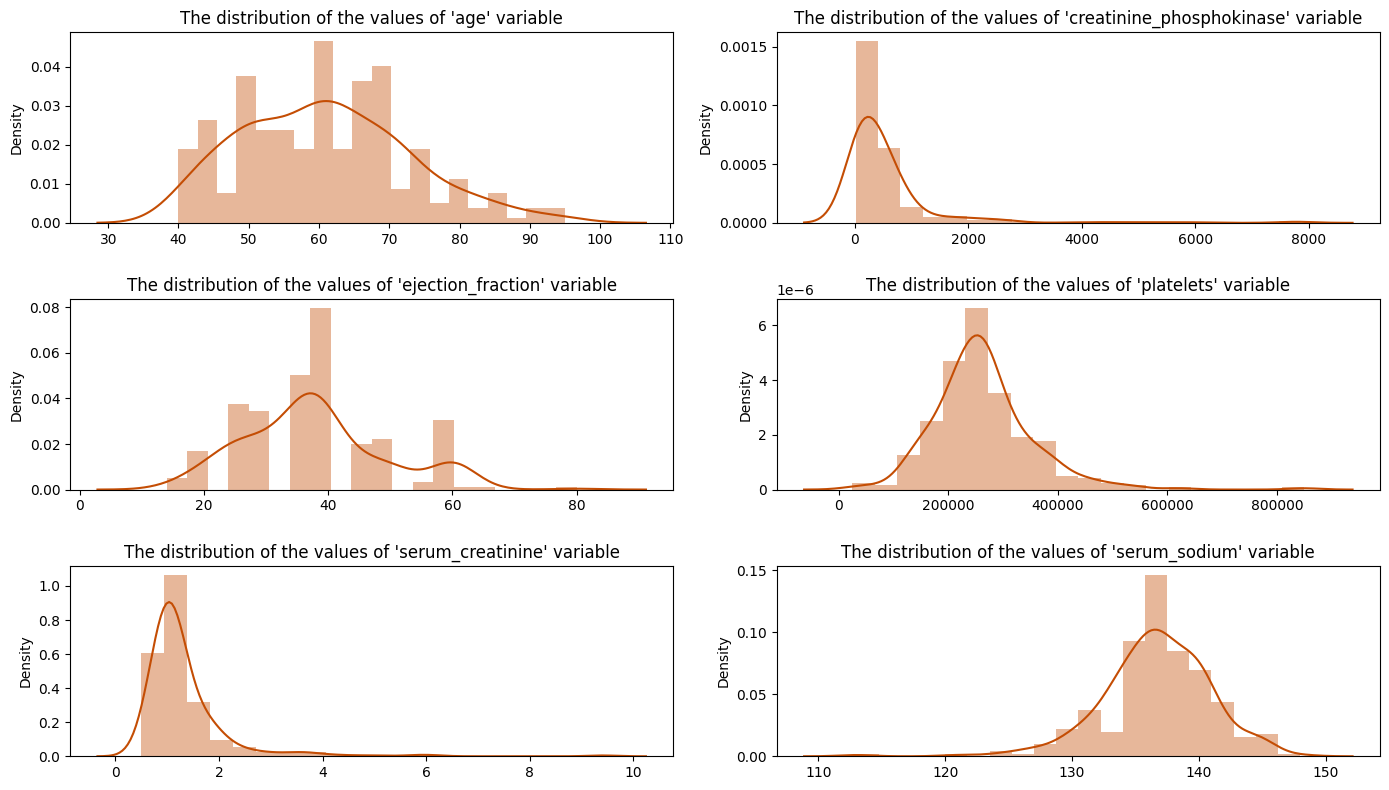

In [34]:
columns_to_plot = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine','serum_sodium']
fig, axes = plt.subplots(3, 2, figsize=(14,8))

# Flattening the axes array for easier iteration
axes = axes.flatten()

# Setting up Bar plots
for i, ax in enumerate(axes[:len(columns_to_plot)]):
    column = columns_to_plot[i]
    sns.distplot(ax = ax, x = new_df[column],
                hist = True,
                bins = 20, 
                kde = True,
                vertical = False, color = "#C44D04").set(title = f"The distribution of the values of '{column}' variable");

# sns.distplot(ax = axes[1], x = df["platelets"],
#              hist = True,
#              bins = 20,
#              kde = True,
#              vertical = False, color = "#FA8B47").set(title = "The distribution of the values of 'platelets' variable");

# Hiding the remaining subplot(s) if not used
for ax in axes[len(columns_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Analyzing Density Plots for Age

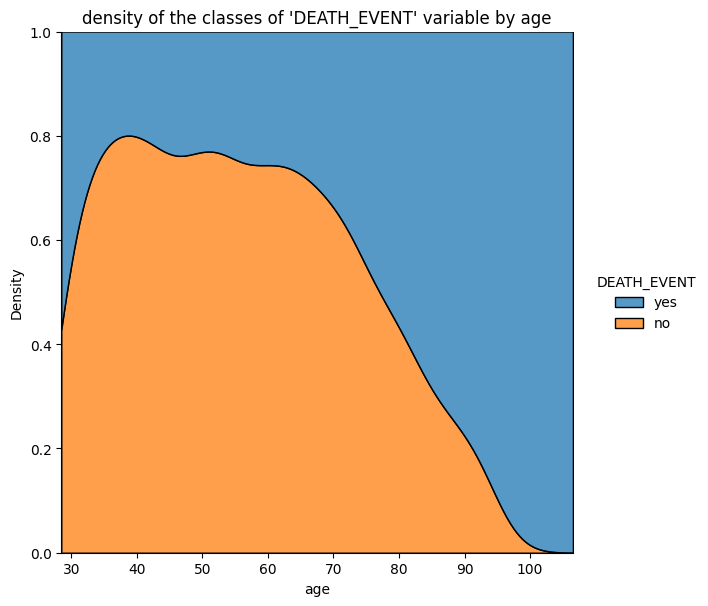

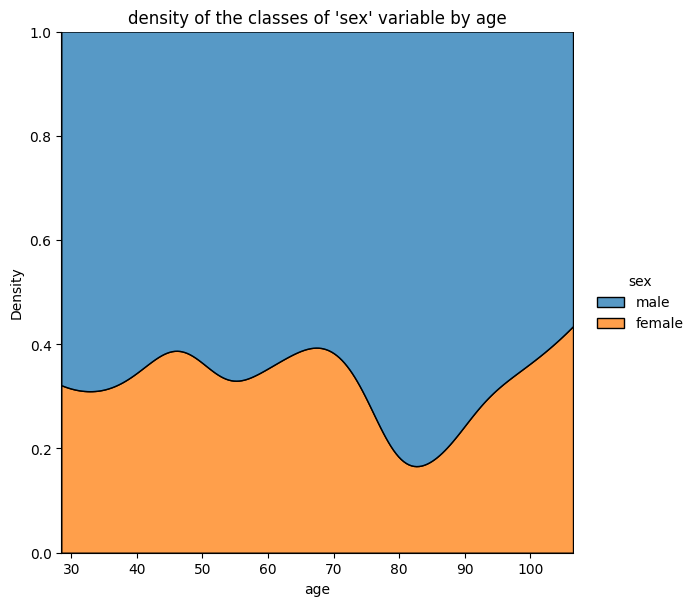

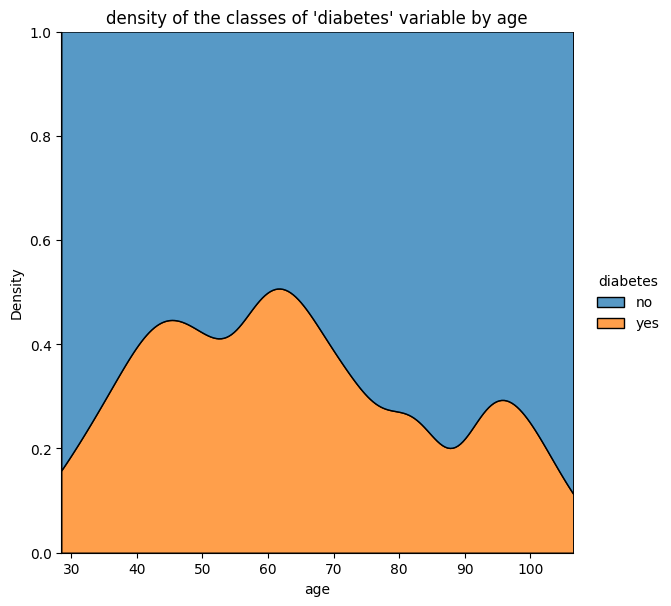

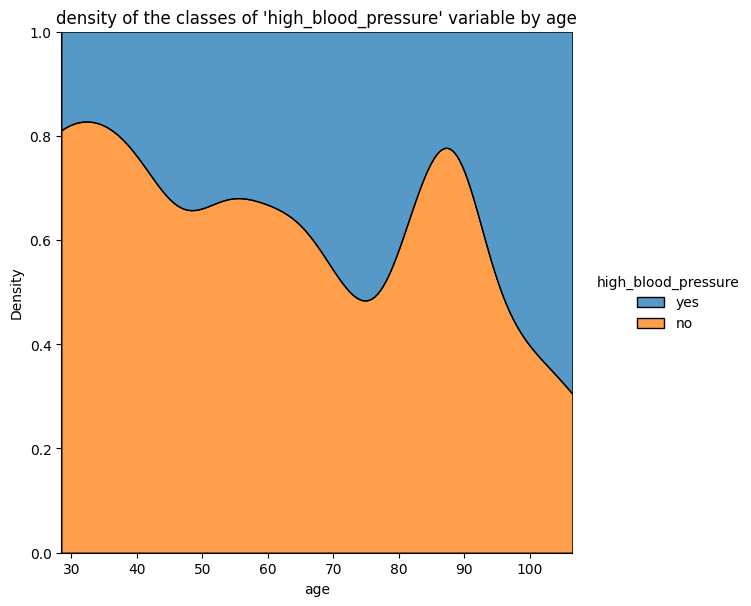

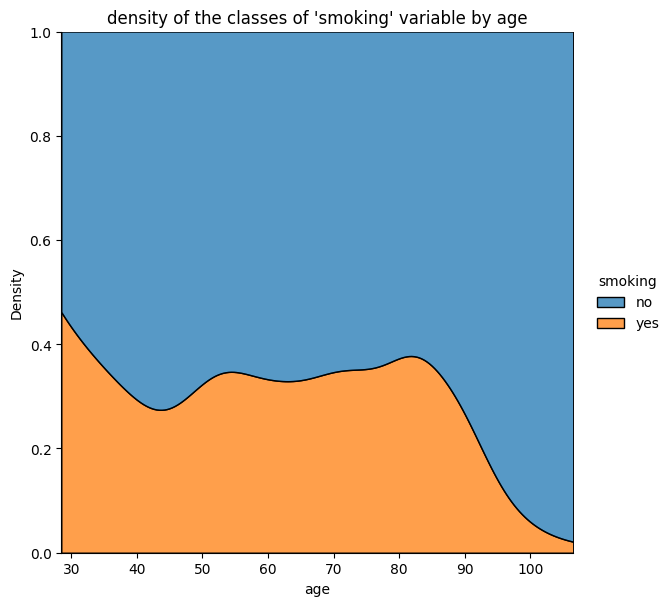

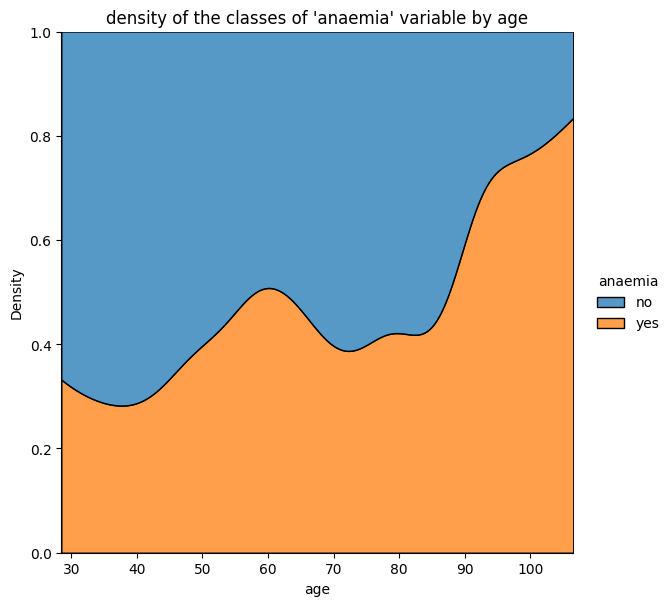

In [35]:
columns_to_plot = ['DEATH_EVENT','sex', 'diabetes', 'high_blood_pressure', 'smoking','anaemia', 'serum_creatinine']
# fig, axes = plt.subplots(3, 2, figsize=(20, 10))
# Flattening the axes array for easier iteration
# axes = axes.flatten()

# Setting up Bar plots
for i, ax in enumerate(axes[:len(columns_to_plot)]):
    column = columns_to_plot[i]
    sns.displot(ax=ax,
                data = new_df,
                x = "age", hue = column,
                kind="kde", height=6,
                multiple="fill", clip=(0, None),
                color = "#FE6203",
                ).set(title = f"density of the classes of '{column}' variable by age")




Heatmap of normalized data

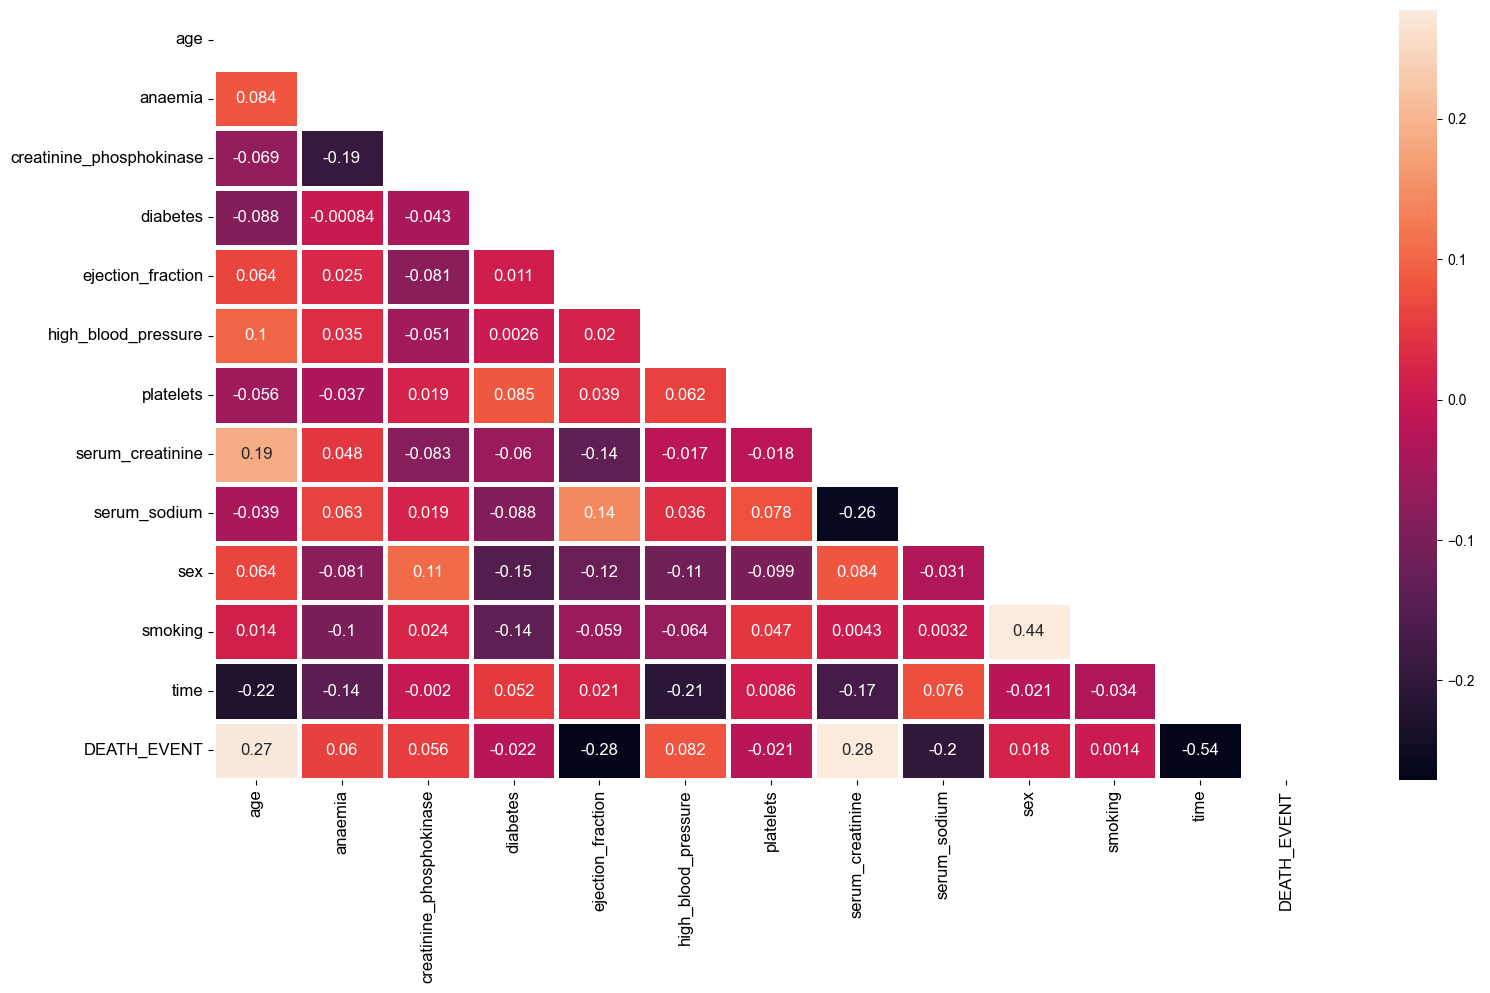

In [36]:
mask = np.zeros_like(norm_df.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True


plt.figure(figsize = (18, 10))
sns.heatmap(norm_df.corr(), mask = mask, annot = True, annot_kws = {"size": 12}, robust = True, linewidths = 2.5)
sns.set_style(style = "darkgrid")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Remarks:
here we see that the death event has very poor corrolation with time and a partially low corrolation with ejection_fraction and serum_sodium.

Dropping the time, ejection_fraction, and serum_sodium columns from both scaled and non-scaled dataframes

# Dropping Columns based on Observations

In [37]:

columns_to_drop = ['time', 'ejection_fraction', 'serum_sodium']  # List of column names to drop
new_df = new_df.drop(columns=columns_to_drop)
print(new_df.shape)
new_df.head()

(289, 10)


age anaemia  creatinine_phosphokinase diabetes high_blood_pressure  \
0  75.0      no                       582       no                 yes   
1  55.0      no                      7861       no                  no   
2  65.0      no                       146       no                  no   
3  50.0     yes                       111       no                  no   
4  90.0     yes                        47       no                 yes   

   platelets  serum_creatinine   sex smoking DEATH_EVENT  
0  265000.00               1.9  male      no         yes  
1  263358.03               1.1  male      no         yes  
2  162000.00               1.3  male     yes         yes  
3  210000.00               1.9  male      no         yes  
4  204000.00               2.1  male     yes         yes

# DATA SPLIT

Splitting the data into Features and Target Variables

In [38]:
# features = new_df.drop(columns=['DEATH_EVENT'])
norm_features = norm_df.drop(columns=['DEATH_EVENT'])
target = norm_df['DEATH_EVENT'] # target will be used with both models since the column is the same as the non-scaled




Splitting data into training and testing samples

In [39]:
norm_features_train, norm_features_test, target_train, target_test = train_test_split(norm_features, target, train_size=0.7, test_size=0.3, random_state=0)
# features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.7, test_size=0.3, random_state=0)

# TREE BASE MODELS

Random Forest Model: Hyperparameter Tuning

training accuracy: 1.0
testing accuracy: 0.8620689655172413


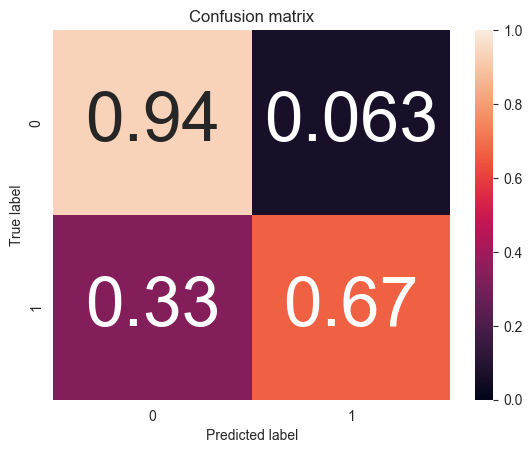

In [40]:
# param_grid = {
#     "max_depth": [1,2,3,5,8],
#     "max_features": [0.5,1,'auto'],
#     "n_estimators": [10, 500, 1000],
#     "min_samples_split": [2,5,8]
# }


rf_model = RandomForestClassifier()
rf_model.fit(norm_features_train,target_train)
prediction_test = rf_model.predict(X=norm_features_test)

print(f'training accuracy: {rf_model.score(norm_features_train,target_train)}')
print(f'testing accuracy: {rf_model.score(norm_features_test,target_test)}')

# confusion matrix
conf_mat = confusion_matrix(target_test,prediction_test)
conf_mat_norm = conf_mat/conf_mat.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_confusion_matrix(conf_mat_norm , classes=rf_model.classes_)

Hyperparameter Tuning

In [41]:
param_grid = {
    "max_depth": [1,2,3,5,8],
    "max_features": [0.5,1,'auto'],
    "n_estimators": [10, 500, 1000],
    "min_samples_split": [2,5,8]
}


rf_model = RandomForestClassifier()
# Searching the best parameter with GridSearchCV()
rf_cv_model = GridSearchCV(rf_model, param_grid, cv = 10, n_jobs= -1)
rf_cv_model.fit(norm_features_train, target_train)
rf_model.fit(norm_features_train,target_train)
# prediction_test = rf_model.predict(X=norm_features_test)

# print(f'training accuracy: {rf_model.score(norm_features_train,target_train)}')
# print(f'testing accuracy: {rf_model.score(norm_features_test,target_test)}')

# # confusion matrix
# conf_mat = confusion_matrix(target_test,prediction_test)
# conf_mat_norm = conf_mat/conf_mat.sum(axis=1)[:,np.newaxis]
# plt.figure()
# plot_confusion_matrix(conf_mat_norm , classes=rf_model.classes_)

/Users/bakerhabhab/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bakerhabhab/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bakerhabhab/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bakerhabhab/anaconda3/envs/my-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse i

RandomForestClassifier()

In [42]:
# get the best parametres
rf_cv_model.best_params_

{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 500}

Building Random Forest Model with Best Parameters

In [43]:
rf_model = RandomForestClassifier(n_estimators = rf_cv_model.best_params_["n_estimators"],
                                max_depth = rf_cv_model.best_params_["max_depth"],
                                max_features = rf_cv_model.best_params_["max_features"],
                                min_samples_split = rf_cv_model.best_params_["min_samples_split"])
rf_model.fit(norm_features_train, target_train)

RandomForestClassifier(max_depth=8, max_features='auto', min_samples_split=5,
                       n_estimators=500)

In [44]:

y_pred = rf_model.predict(X=norm_features_test)
print(f'training accuracy: {rf_model.score(norm_features_train,target_train)}\n')
print(f'testing accuracy: {rf_model.score(norm_features_test,target_test)}\n')
print(f'testing accuracy score: {accuracy_score(target_test, y_pred)}\n')
print(f'Classification report:\n{classification_report(target_test, y_pred)}')



training accuracy: 0.995049504950495

testing accuracy: 0.8620689655172413

testing accuracy score: 0.8620689655172413

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.80      0.67      0.73        24

    accuracy                           0.86        87
   macro avg       0.84      0.80      0.82        87
weighted avg       0.86      0.86      0.86        87

